In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy
from scipy import signal
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.df import streamgapdf, impulse_deltav_plummer_curvedstream
from galpy.util import bovy_conversion, bovy_coords
try:
    reload(galpy.df)
except NameError:
    import galpy.df
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_plot
%pylab inline
R0, V0= 8., 220.

Populating the interactive namespace from numpy and matplotlib


# Some improvements in the streamgapdf code

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)
sdfl_per_1e8_peri= galpy.df.streamgapdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                        leading=False,nTrackChunks=26,nTrackIterations=0,
                                        sigMeanOffset=4.5,
                                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        Vnorm=V0,Rnorm=R0,
                                        impactb=0.,
                                        subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0, # from Denis' email
                                        timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        impact_angle=-2.34,
                                        GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                        rs=0.625/R0) 

/Users/bovy/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)



## Improved smoothness in the calculated kicks by averaging the Jacobians of nearby points

The kicks are now quite smooth, see the parallel frequency kick (at a few different times here)

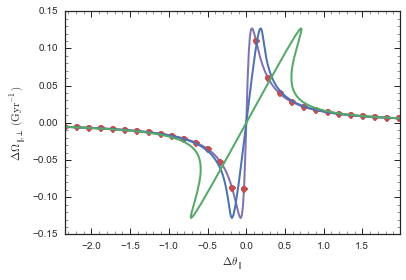

In [4]:
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle+
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*0.88/bovy_conversion.time_in_Gyr(V0,R0),
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*bovy_conversion.freq_in_Gyr(V0,R0),
                    '-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega_{\parallel,\perp}\,(\mathrm{Gyr}^{-1})$',
                    yrange=[-0.15,0.15])
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle+
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*5./bovy_conversion.time_in_Gyr(V0,R0),
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*bovy_conversion.freq_in_Gyr(V0,R0),
                    '-',lw=2.,overplot=True)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._gap_thetasTrack-sdfl_per_1e8_peri._impact_angle,
                   sdfl_per_1e8_peri._kick_interpdOpar(sdfl_per_1e8_peri._gap_thetasTrack)*bovy_conversion.freq_in_Gyr(V0,R0),
                    'o',overplot=True,zorder=1)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*bovy_conversion.freq_in_Gyr(V0,R0),
                    '-',lw=2.,zorder=0,
                    overplot=True)

## Calculation of mean frequency as a function of angle

In [5]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df.streamgapdf,sdfl_per_1e8_peri).meanOmega(x,oned=True) for x in xs])

Compare to mock simulation, lowess estimate of the trend in the mock data shown in red, agrees with calculation in blue

In [6]:
numpy.random.seed(1)
aa_mock_per= sdfl_per_1e8_peri.sample(n=100000,returnaAdt=True)
Opar= numpy.dot(aa_mock_per[0].T-sdfl_per_1e8_peri._progenitor_Omega,sdfl_per_1e8_peri._dsigomeanProgDirection)
apar= numpy.dot(aa_mock_per[1].T-sdfl_per_1e8_peri._progenitor_angle,sdfl_per_1e8_peri._dsigomeanProgDirection)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(Opar,apar,frac=0.01)

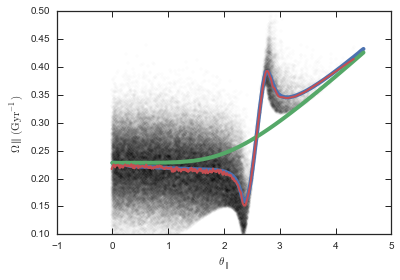

In [7]:
plot(apar,Opar*bovy_conversion.freq_in_Gyr(V0,R0),'k.',alpha=0.01)
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(z[:,0],z[:,1]*bovy_conversion.freq_in_Gyr(V0,R0),lw=2.)
ylim(0.1,0.5)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega\parallel\,(\mathrm{Gyr}^{-1})$')

## Calculation of density as a function of angle

In [8]:
xs= numpy.linspace(0.,4.5,101)
dens= numpy.array([sdfl_per_1e8_peri.density_par(x) for x in xs])
dens_unp= numpy.array([super(galpy.df.streamgapdf,sdfl_per_1e8_peri).density_par(x) for x in xs])

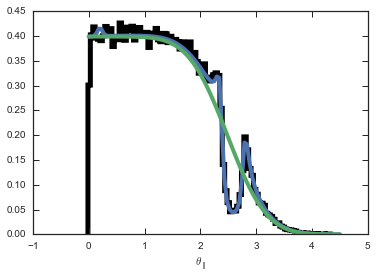

In [9]:
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
dum= hist(apar,bins=101,normed=True,histtype='step',color='k',zorder=0,lw=5.)
xlabel(r'$\theta_\parallel$')